### Look at periportal and pericentral hepatocyte/endothelial cell spatial statistics

In [11]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import squidpy as sq
from fs import open_fs
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm
from skimage.measure import block_reduce
import tifffile
import string

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
# Function to preprocess raw AnnData object

def preprocess_ad(ad, min_counts):
    ad.layers['counts'] = ad.X.copy()
    sc.pp.filter_cells(ad, min_counts=min_counts)
    sc.pp.normalize_total(ad, target_sum=1e4) # Normalize data
    sc.pp.log1p(ad) # Logarithmize the data
    #sc.pp.scale(ad) # Scale each gene to unit variance

In [2]:
# Load data
fileDir = '/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/results/'

VizgenLiver = ad.read_h5ad(fileDir + 'MERFISH_liver_object.h5ad')

# Rotate coordinates for liver to make the aspect ratio nicer
VizgenLiver.obsm['spatial'] = VizgenLiver.obsm['spatial'][:,[1,0]].copy()

# Create abbreviated cell type labels
liver_abbrev_map = {'immune cell': 'IC',
                   'other endothelial cell': 'o-EC',
                   'Kupffer cell': 'KC',
                   'hepatic stellate cell': 'HSC',
                   'other hepatocyte': 'o-hep',
                   'periportal hepatocyte': 'PP-hep',
                   'pericentral hepatocyte': 'PC-hep',
                   'periportal endothelial cell': 'PP-EC',
                   'pericentral endothelial cell': 'PC-EC'}
kidney_abbrev_map = {'epithelial cell of proximal tubule':'EC-PT',
                    'immune cell': 'IC',
                    'pericyte':'per',
                    'kidney loop of Henle epithelial cell':'KLH-EC',
                    'kidney collecting duct epithelial cell':'KCD-EC',
                    'kidney distal convoluted tubule epithelial cell':'KDCT-EC',
                    'endothelial cell': 'EC',
                    'podocyte':'pod',
                    'fibroblast':'fib'}

VizgenLiver.obs['tentative_annot_abv'] = VizgenLiver.obs['tentative_annot'].map(liver_abbrev_map)

print('Results loaded.')

Results loaded.


<Figure size 640x480 with 0 Axes>

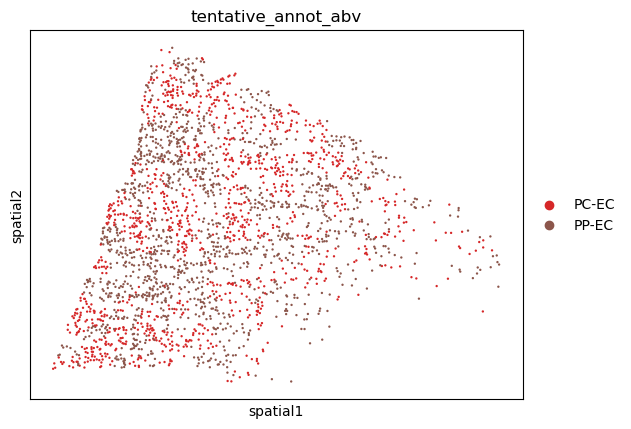

<Figure size 640x480 with 0 Axes>

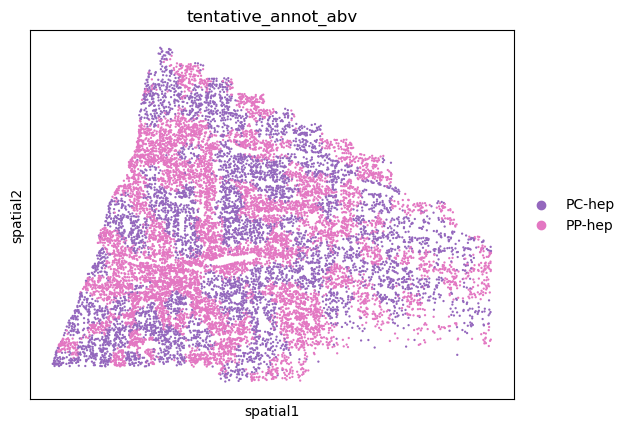

In [10]:
# Spatial plot of hepatocytes and endothelial cells
plt.figure()
sc.pl.spatial(VizgenLiver[
    VizgenLiver.obs['tentative_annot_abv'].isin(['PP-EC',
                                                'PC-EC'])], color='tentative_annot_abv', spot_size=30)
plt.show()

plt.figure()
sc.pl.spatial(VizgenLiver[
    VizgenLiver.obs['tentative_annot_abv'].isin(['PP-hep',
                                                'PC-hep'])], color='tentative_annot_abv', spot_size=30)
plt.show()

In [80]:
# Calculate squidpy spatial neighbors
# sq.gr.spatial_neighbors(adata, n_neighs=10, coord_type="generic")
# _, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
# idx = np.append(idx, 420)
# sc.pl.spatial(
#     adata[idx, :],
#     color="cell type",
#     neighbors_key="spatial_neighbors",
#     spot_size=1,
#     edges=True,
#     edges_width=1,
#     img_key=None,
# )
sq.gr.spatial_neighbors(VizgenLiver, n_neighs=10, coord_type='generic')

# Create dataframe for storing number of cell types for each cell's spatial neighbors
LiverSpatialNeighbors = pd.DataFrame(
    index=VizgenLiver.obs.index,
    columns=VizgenLiver.obs['tentative_annot_abv'].unique())

# Count number of each cell type in spatial neighbors for each cell
for i in tqdm(range(LiverSpatialNeighbors.shape[0])):
    # List of indices of spatial neighbors
    _, idx = VizgenLiver.obsp["spatial_connectivities"][i, :].nonzero()
    
    # Get the cell types for these spatial neighbors
    neighbor_annot = VizgenLiver.obs['tentative_annot_abv'][idx]
    
    # Count the frequency of occurrences of each cell type among the spatial neighbors
    LiverSpatialNeighbors.iloc[i,:] = neighbor_annot.value_counts() / len(neighbor_annot)
    
# Add a column for other (sum of non-hepatocytes and endothelial)
LiverSpatialNeighbors['other'] = LiverSpatialNeighbors[['KC','HSC','IC']].sum(axis=1)
    
print('Spatial neighbors assigned and identified.')

100%|███████████████████████████████████| 19695/19695 [00:14<00:00, 1328.41it/s]

Spatial neighbors assigned and identified.


In [93]:
# Create a dataframe storing the spatial statistics
LiverSpatialStatistics = pd.DataFrame(index=['PC-hep','PP-hep','PC-EC','PP-EC'],
                                     columns=['PC-hep','PP-hep','PC-EC','PP-EC','other'])
for i in range(LiverSpatialStatistics.shape[0]):
    celltype = LiverSpatialStatistics.iloc[i,:].name # Cell type of interest
    ind = VizgenLiver.obs['tentative_annot_abv'] == celltype # Indices for this cell type
    df_celltype = LiverSpatialNeighbors.loc[ind,:] # Dataframe for this cell type
    
    # Calculate mean and standard deviation of neighbor frequencies
    for c in LiverSpatialStatistics.columns:
        LiverSpatialStatistics.loc[celltype,c] = df_celltype[c].mean()

In [95]:
LiverSpatialStatistics

,PC-hep,PP-hep,PC-EC,PP-EC,other
PC-hep,0.630332,0.099598,0.003002,0.04587,0.221122
PP-hep,0.683192,0.085227,0.002191,0.037496,0.191894
PC-EC,0.615054,0.105128,0.004378,0.051943,0.223496
PP-EC,0.670397,0.092413,0.002949,0.041636,0.192604


This is not super informative. Let's try a different approach.

In [101]:
# Get just the hepatocytes and endothelial cells
VizgenSubset = VizgenLiver[VizgenLiver.obs['tentative_annot_abv'].isin(['PP-EC',
                                                                        'PC-EC',
                                                                        'PP-hep',
                                                                        'PC-hep'])].copy()

# Calculate squidpy co-occurrence
sq.gr.co_occurrence(VizgenSubset,'tentative_annot_abv')

  0%|          | 0/1 [00:00<?, ?/s]

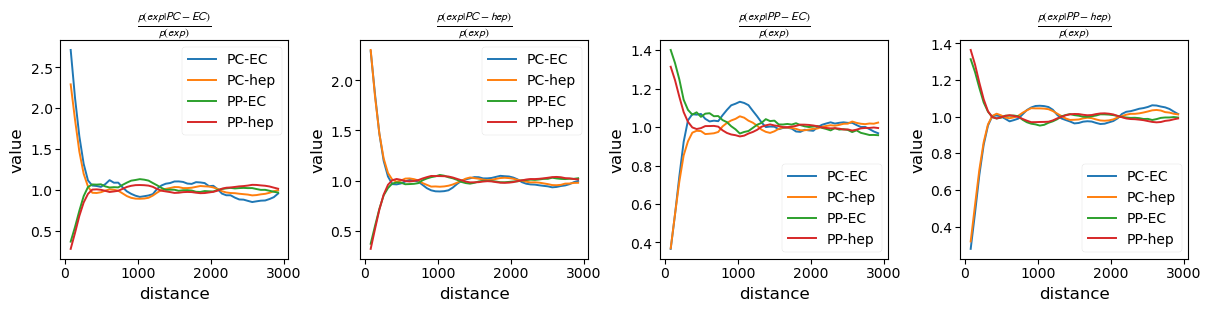

In [135]:
# Plot co-occurrence
set_plotting_style()

sq.pl.co_occurrence(VizgenSubset, cluster_key="tentative_annot_abv", figsize=(12,3),
                   palette='tab10',legend_kwargs={'loc':'best'})

plt.show()

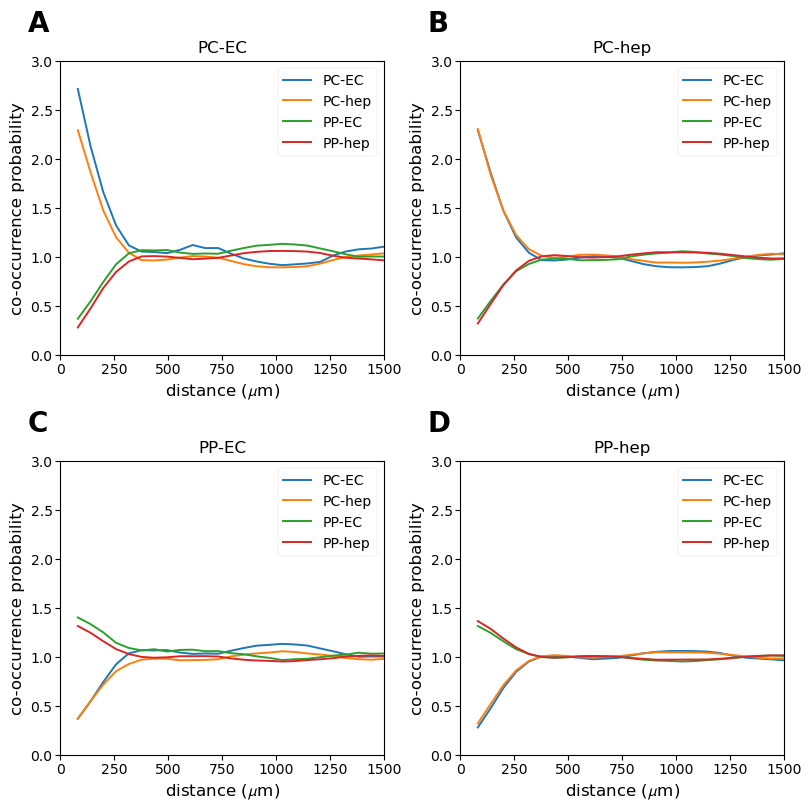

In [164]:
# Plot co-occurrence
set_plotting_style()
clusters = ['PC-EC','PC-hep','PP-EC','PP-hep']
occ = VizgenSubset.uns['tentative_annot_abv_co_occurrence']['occ']
dist = VizgenSubset.uns['tentative_annot_abv_co_occurrence']['interval'][1:]

fig, axes = plt.subplots(2,2,figsize=(8,8), constrained_layout=True)
for i, ax in zip(range(len(clusters)), axes.flatten()):
    for j in range(len(clusters)):
        ax.plot(dist,occ[i,j,:],label=clusters[j])
    ax.set_xlim(0,1500)
    ax.set_ylim(0,3)
    ax.set_xlabel('distance ($\mu$m)')
    ax.set_ylabel('co-occurrence probability')
    ax.set_title(clusters[i])
    ax.legend()
    
# Label subpanels
axes_label = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]
for n, ax in enumerate(axes_label):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')

plt.show()

In [165]:
# Save the figure
fig.savefig('../../figures/SIFig_liver_cooccurrence.svg', transparent=True)
fig.savefig('../../figures/SIFig_liver_cooccurrence.png', transparent=True)

print('Figures saved.')

Figures saved.
